In [1]:
# Install any missing packages (most are preinstalled)
!pip install wordcloud

# Imports
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download required NLTK resources
nltk.download('stopwords')

print("Environment ready!")


[nltk_data] Downloading package stopwords to /root/nltk_data...


Environment ready!


[nltk_data]   Unzipping corpora/stopwords.zip.


# Introduction

## Problem Overview

This project uses data from a Kaggle competition titled "Natural Language Processing with Disaster Tweets". The challenge is to build a binary text classification model that can predict whether a given tweet is about a real disaster (target = 1) or not (target = 0).

This is a classic problem in Natural Language Processing (NLP) — the field of machine learning that focuses on understanding and generating human language. The task is well-suited for deep learning models such as LSTMs, which can capture sequential patterns in text data.

## Dataset Description

Training data: train.csv — contains both tweet text and the target label.

Test data: test.csv — contains only tweet text; your model predicts the target.

Sample submission: sample_submission.csv — a template for submitting results to Kaggle.

| Column     | Description                                                          |
| ---------- | -------------------------------------------------------------------- |
| `id`       | Unique identifier for each tweet                                     |
| `keyword`  | Disaster-related keyword (may be missing)                            |
| `location` | Location where tweet was sent from (may be missing)                  |
| `text`     | The content of the tweet                                             |
| `target`   | Binary label: 1 = real disaster tweet, 0 = not a real disaster tweet |


In [2]:
import pandas as pd

# No folders needed — they're in the root working directory
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Confirm load
print(train_df.shape)
train_df.head()


(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# EDA

### The goal of this step was to understand the structure of the tweet data and prepare it for modeling through inspection, visualization, and cleaning.

### Display shape,  first few rows of each data set, and NaN values

In [3]:
# Display the shape and first few rows of each
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

print("\nTrain Data Sample:")
display(train_df.head())


print("\nTest Data Sample:")
display(test_df.head())

# Check for missing values
print("\nMissing values in Train Data:")
print(train_df.isnull().sum())

print("\nMissing values in Test Data:")
print(test_df.isnull().sum())

Train Data Shape: (7613, 5)
Test Data Shape: (3263, 4)

Train Data Sample:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



Test Data Sample:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan



Missing values in Train Data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in Test Data:
id             0
keyword       26
location    1105
text           0
dtype: int64


Initial inspection revealed:

- The keyword and location fields contain missing values.

- The text field (tweet content) is the primary input feature.

- The target field is binary: 1 for disaster tweets and 0 for non-disaster tweets.

### Data Cleaning

We applied the following preprocessing steps:

- Decoded URL-encoded keywords (e.g., %20 → space).

- Cleaned text: lowercased all words, removed URLs, HTML tags, punctuation/special characters, and stopwords.

- Created binary feature has_location to indicate whether the tweet had a location.

- Replaced missing keyword values with "missing".

- Dropped tweets with fewer than 3 words and removed duplicate tweets based on cleaned text.

remove url encoded text (i.e. %20 instead of spaces)

In [4]:
from urllib.parse import unquote

train_df['keyword'] = train_df['keyword'].apply(lambda x: unquote(unquote(x)) if pd.notnull(x) else x)
test_df['keyword'] = test_df['keyword'].apply(lambda x: unquote(unquote(x)) if pd.notnull(x) else x)


Define and apply cleaning functions

*   lowercase all text
*   remove URLs
*   remove punctuation and special char
*   remove stopwords

Replace NaN Keyword values with 'missing'.


Change location to either 0 or 1 for does not have and has, respectively.


In [5]:
# === STEP 1: Import and Download NLTK Stopwords Only ===
import nltk
nltk.download('stopwords')

# === STEP 2: Import Required Libraries ===
import pandas as pd
import re
from nltk.corpus import stopwords

# === STEP 3: Load the Data ===
# train_df = pd.read_csv('data/train.csv')
# test_df = pd.read_csv('data/test.csv')

# === STEP 4: Define Cleaning Functions ===
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()                                  # lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)     # remove URLs
    text = re.sub(r'<.*?>', '', text)                     # remove HTML
    text = re.sub(r'[^a-z0-9\s]', '', text)               # remove punctuation/special characters
    tokens = re.findall(r'\b\w+\b', text)                 # regex-based tokenization
    tokens = [w for w in tokens if w not in stop_words]   # remove stopwords
    return " ".join(tokens)

def clean_keyword(keyword):
    return keyword.lower() if pd.notnull(keyword) else "missing"

def has_location(loc):
    return 0 if pd.isnull(loc) else 1

# === STEP 5: Apply Cleaning to Train/Test Data ===
train_df['keyword'] = train_df['keyword'].apply(clean_keyword)
train_df['has_location'] = train_df['location'].apply(has_location)
train_df['clean_text'] = train_df['text'].apply(clean_text)

test_df['keyword'] = test_df['keyword'].apply(clean_keyword)
test_df['has_location'] = test_df['location'].apply(has_location)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# === STEP 6: Drop Unused Columns ===
train_clean = train_df.drop(columns=['id', 'location', 'text'])
test_clean = test_df.drop(columns=['id', 'location', 'text'])

# === STEP 7: Preview Cleaned Data ===
print(train_clean.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   keyword  target  has_location  \
0  missing       1             0   
1  missing       1             0   
2  missing       1             0   
3  missing       1             0   
4  missing       1             0   

                                          clean_text  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  13000 people receive wildfires evacuation orde...  
4  got sent photo ruby alaska smoke wildfires pou...  


### Target Class (Label) Distribution

The dataset is moderately imbalanced:

~4,300 non-disaster tweets (target = 0)

~3,300 disaster tweets (target = 1)

This guided the decision to monitor precision and recall alongside accuracy during modeling.

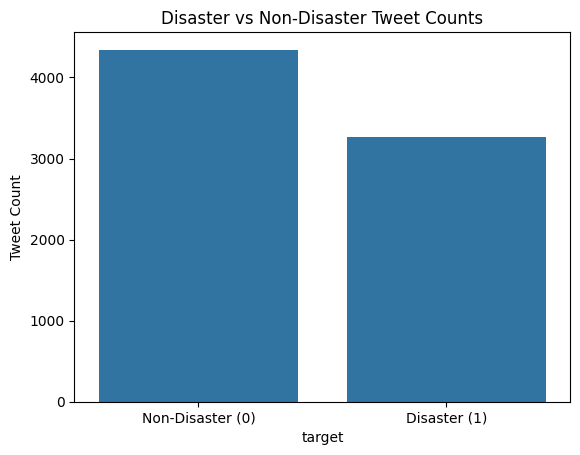

target
0    4342
1    3271
Name: count, dtype: int64


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot target distribution
sns.countplot(data=train_clean, x='target')
plt.title("Disaster vs Non-Disaster Tweet Counts")
plt.xticks([0, 1], ['Non-Disaster (0)', 'Disaster (1)'])
plt.ylabel("Tweet Count")
plt.show()

# Print actual counts
print(train_clean['target'].value_counts())

### Keyword Frequency Analysis

We visualized the most frequent keywords in disaster vs. non-disaster tweets.

Disaster tweets commonly included terms like "missing", "derailment", "wreckage", and "evacuated".

Non-disaster tweets used dramatic but figurative language like "armageddon", "panic", and "screaming".

This helped confirm that the keyword field could carry useful semantic signal if properly embedded.

<ipython-input-7-8003dd4a51a1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=disaster_df, x='count', y='keyword', ax=axes[0], palette='Reds_r')
<ipython-input-7-8003dd4a51a1>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=nondisaster_df, x='count', y='keyword', ax=axes[1], palette='Blues_r')


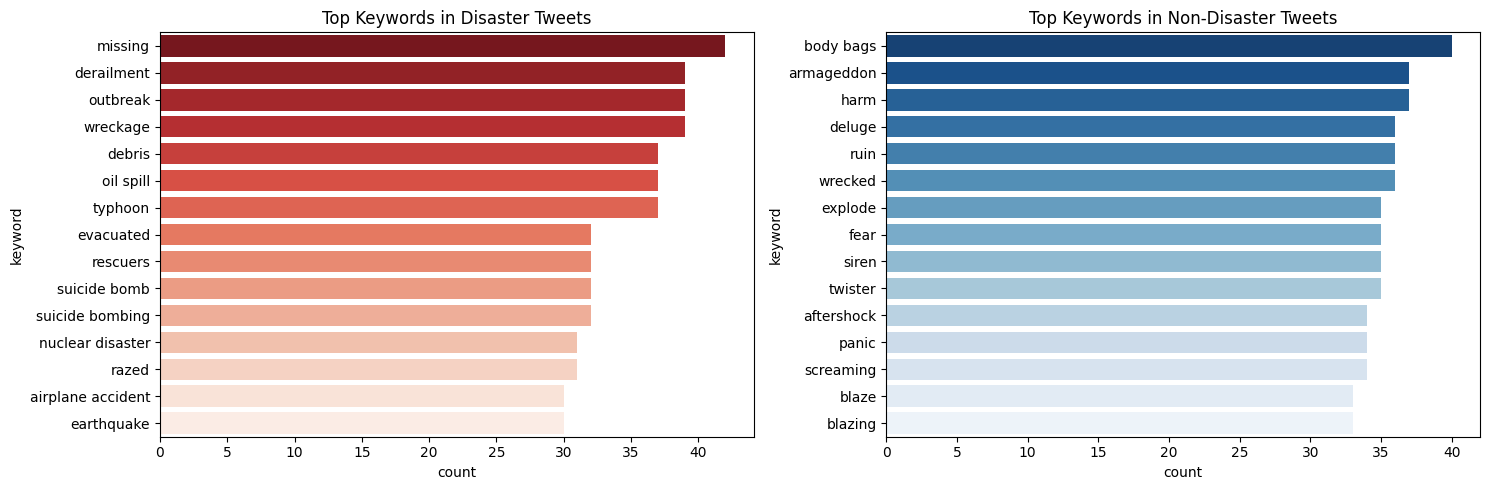

In [7]:
from collections import Counter

# Top keywords in each class
top_disaster_keywords = Counter(train_clean[train_clean['target'] == 1]['keyword']).most_common(15)
top_nondisaster_keywords = Counter(train_clean[train_clean['target'] == 0]['keyword']).most_common(15)

# Convert to DataFrames for plotting
disaster_df = pd.DataFrame(top_disaster_keywords, columns=['keyword', 'count'])
nondisaster_df = pd.DataFrame(top_nondisaster_keywords, columns=['keyword', 'count'])

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(data=disaster_df, x='count', y='keyword', ax=axes[0], palette='Reds_r')
axes[0].set_title("Top Keywords in Disaster Tweets")

sns.barplot(data=nondisaster_df, x='count', y='keyword', ax=axes[1], palette='Blues_r')
axes[1].set_title("Top Keywords in Non-Disaster Tweets")

plt.tight_layout()
plt.show()


### Word Cloud Disaster vs Non-Disaster

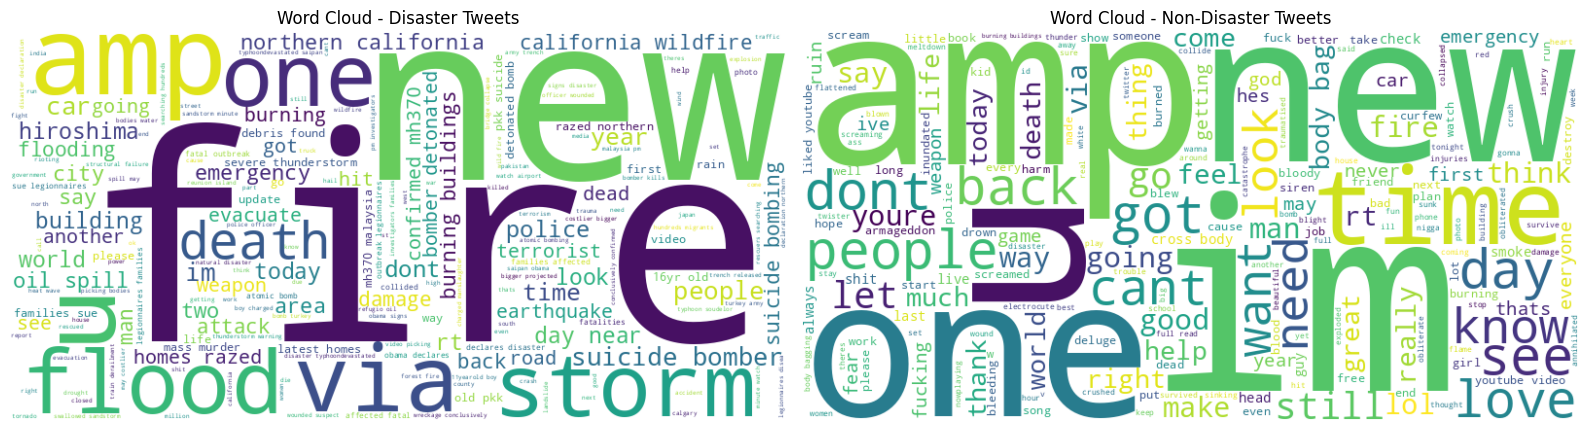

In [8]:
from wordcloud import WordCloud

# Join all clean_text entries for each class
disaster_words = " ".join(train_clean[train_clean['target'] == 1]['clean_text'])
nondisaster_words = " ".join(train_clean[train_clean['target'] == 0]['clean_text'])

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

wc1 = WordCloud(width=800, height=400, background_color='white').generate(disaster_words)
axes[0].imshow(wc1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Word Cloud - Disaster Tweets")

wc2 = WordCloud(width=800, height=400, background_color='white').generate(nondisaster_words)
axes[1].imshow(wc2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Word Cloud - Non-Disaster Tweets")

plt.tight_layout()
plt.show()

### Tweet length distributions - Character and Word Count

Both classes spike near 140 characters — likely due to Twitter’s old 140-character limit.

Disaster tweets (blue) are slightly more spread out and tend to be longer on average than non-disaster tweets.

Word count distribution is similar: disaster tweets often contain more words, suggesting more descriptive content.

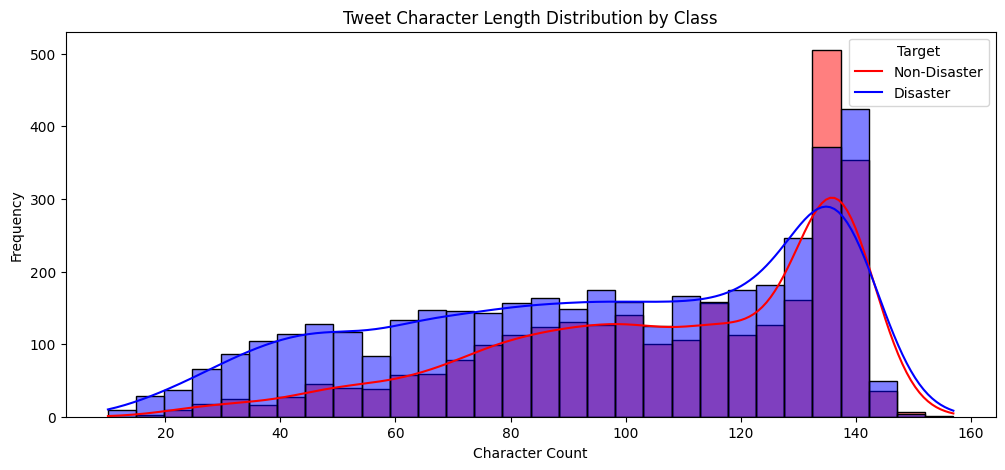

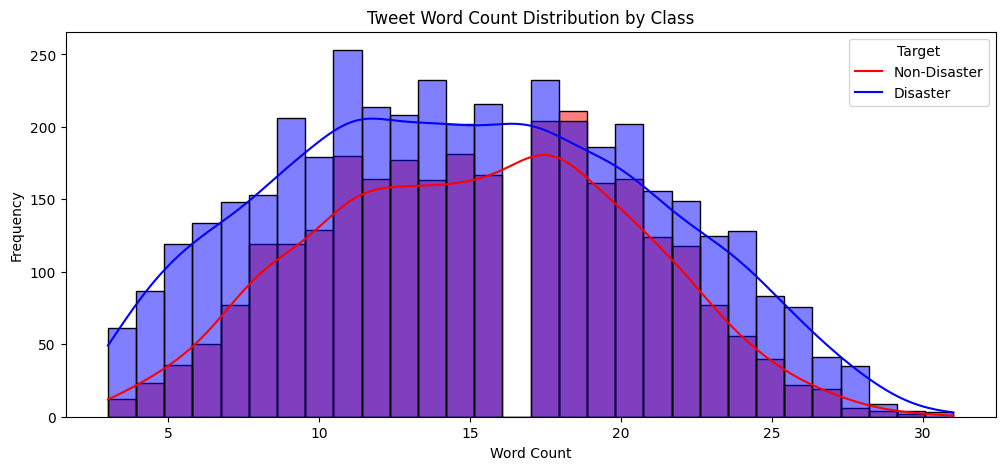

In [35]:
# Add tweet length columns
train_clean['char_count'] = train_df['text'].apply(len)
train_clean['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# Plot character count distributions
plt.figure(figsize=(12, 5))
sns.histplot(data=train_clean, x='char_count', hue='target', bins=30, kde=True, palette={0: 'blue', 1: 'red'})
plt.title("Tweet Character Length Distribution by Class")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.legend(title='Target', labels=['Non-Disaster', 'Disaster'])
plt.show()

# Plot word count distributions
plt.figure(figsize=(12, 5))
sns.histplot(data=train_clean, x='word_count', hue='target', bins=30, kde=True, palette={0: 'blue', 1: 'red'})
plt.title("Tweet Word Count Distribution by Class")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend(title='Target', labels=['Non-Disaster', 'Disaster'])
plt.show()


The tweet length distribution plots helped identify potentially uninformative samples:

Tweets with fewer than 3 words were disproportionately short and lacked enough context to meaningfully classify.

Removing these very short tweets helped reduce noise in the training set.

Additionally, we observed a few duplicate tweets, which could bias the model or inflate performance. These were also removed.

In [10]:
#drop very short tweets
train_clean = train_clean[train_clean['word_count'] >= 3]


In [11]:
# Drop duplicate texts
train_clean = train_clean.drop_duplicates(subset='clean_text')


In [12]:
train_clean

,keyword,target,has_location,clean_text,char_count,word_count
0,missing,1,0,deeds reason earthquake may allah forgive us,69,13
1,missing,1,0,forest fire near la ronge sask canada,38,7
2,missing,1,0,residents asked shelter place notified officer...,133,22
3,missing,1,0,13000 people receive wildfires evacuation orde...,65,8
4,missing,1,0,got sent photo ruby alaska smoke wildfires pou...,88,16
...,...,...,...,...,...,...
7601,missing,1,0,breaking la refugio oil spill may costlier big...,99,13
7602,missing,1,0,siren went wasnt forney tornado warning,65,13
7603,missing,1,0,officials say quarantine place alabama home po...,136,20
7605,missing,1,0,flip side im walmart bomb everyone evacuate st...,114,26


# Model Building

## Two Architectures

| Model       | Embedding    | LSTM                          | Trainable | Dropout   | Final Layer     |
| ----------- | ------------ | ----------------------------- | --------- | --------- | --------------- |
| **Model A** | GloVe (100D) | Bidirectional LSTM (64 units) | ❌ No      | 0.5 & 0.3 | Dense → Sigmoid |
| **Model B** | GloVe (100D) | Bidirectional LSTM (64 units) | ✅ Yes     | 0.5 & 0.3 | Dense → Sigmoid |


- Model A froze the GloVe embeddings to use them as-is.

- Model B allowed GloVe embeddings to be updated during training (trainable=True), enabling the model to adapt them to the language patterns specific to disaster-related tweets.

## Embedding Strategy: GloVe - Global Vectors for Word Representation

a pre-trained word embedding technique that maps words into dense vector space using statistics from a large corpus (like Wikipedia or Common Crawl). Each word is represented as a fixed-length vector (e.g., 100 or 300 dimensions) that captures semantic relationships.

| Reason                              | Explanation                                                                                                                                                            |
| ----------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Pretrained on large corpus**   | GloVe vectors are trained on billions of words, giving strong contextual understanding even for short tweets.                                                          |
| **2. Handles synonyms & semantics** | Words like “evacuate,” “rescue,” and “emergency” will be close in vector space — helping the model generalize.                                                         |
| **3. Solves data sparsity**         | Your dataset is relatively small (\~7,000 tweets), so learning good word embeddings from scratch would be hard. GloVe gives you a head start.                          |
| **4. Speeds up convergence**        | Using pretrained embeddings reduces the burden on the model to learn everything from scratch — your LSTM can focus on temporal relationships, not basic word meanings. |
| **5. Interpretability**             | You can visualize and inspect the embedding layer more meaningfully (e.g., nearest neighbors for a keyword).                                                           |


We incorporated pre-trained word vectors from GloVe (6B, 100D) to provide semantic understanding of words prior to training. Each word was represented by a 100-dimensional vector trained on Wikipedia and Gigaword.

Steps included:

1. Downloading glove.6B.zip and extracting glove.6B.100d.txt

2. Mapping each word in our vocabulary to its corresponding GloVe vector

3. Constructing an embedding matrix that was passed into Keras's Embedding layer

## Download GloVe (100d)

In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2025-05-14 13:43:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-14 13:43:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-14 13:43:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Tokenize Text and Pad Sequences

To convert raw tweet text into a numerical format usable by neural networks, we applied the following steps:

- Tokenization: Used Keras's Tokenizer to convert words into integer indices.

- Truncation and Padding: Tweets were truncated or padded to a fixed length of 30 tokens, based on EDA of tweet word counts.

- Vocabulary Size: Limited to the top 10,000 most frequent words to balance memory efficiency and representation quality.

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_NUM_WORDS = 10000  # Max number of words to keep in tokenizer
MAX_SEQUENCE_LENGTH = 30  # Based on EDA (tweet lengths)
EMBEDDING_DIM = 100  # Using GloVe 100D

# Prepare tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_clean['clean_text'])

# Convert to sequences
train_sequences = tokenizer.texts_to_sequences(train_clean['clean_text'])
test_sequences = tokenizer.texts_to_sequences(test_clean['clean_text'])

# Pad sequences
X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Labels
y_train = train_clean['target'].values


## Load GloVe and Create Embedding Matrix

We loaded pre-trained GloVe word vectors (glove.6B.100d.txt) and built an embedding matrix to map each word in our vocabulary to its corresponding 100-dimensional GloVe vector.

Steps included:

- Parsing each line of the GloVe file to extract the word and its vector representation

- Creating a dictionary mapping (embedding_index)

- Initializing a zero matrix with shape (vocab_size, 100)

- Populating each row with the GloVe vector corresponding to the word's index from the tokenizer

If a word from the dataset was not found in GloVe, it remained as a zero vector (this accounts for out-of-vocabulary words).-

In [15]:
import numpy as np

# Load GloVe word vectors
glove_path = "glove.6B.100d.txt"
embedding_index = {}

with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Prepare embedding matrix
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


## Build the LSTM Model with GloVe Embeddings - Implementation in Keras

Using TensorFlow's Keras API, we built a bidirectional LSTM model that included:

- An embedding layer initialized with our GloVe matrix

- A Bidirectional LSTM layer with 64 units

- Two Dropout layers to prevent overfitting (rates of 0.5 and 0.3)

- A Dense layer with ReLU activation

- A final sigmoid layer for binary classification (disaster vs. non-disaster)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Define model
model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),  # Freeze GloVe weights
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

## Train the Model

In [18]:
from sklearn.model_selection import train_test_split

# Split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Train
history = model.fit(X_tr, y_tr,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=64)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.6697 - loss: 0.6185 - val_accuracy: 0.7723 - val_loss: 0.4893
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.7970 - loss: 0.4559 - val_accuracy: 0.7839 - val_loss: 0.4690
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8040 - loss: 0.4447 - val_accuracy: 0.7606 - val_loss: 0.4820
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.8095 - loss: 0.4401 - val_accuracy: 0.7788 - val_loss: 0.4648
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.8283 - loss: 0.4007 - val_accuracy: 0.7942 - val_loss: 0.4634
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8197 - loss: 0.4138 - val_accuracy: 0.7942 - val_loss: 0.4565
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.8321 - loss: 0.3895 - val_accuracy: 0.7985 - val_loss: 0.4667
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8486 - loss: 0.3700 - val_accuracy: 0.8007 

## Plot Training and Validation Accuracy Loss

## Training Performance Observations

Training accuracy improved steadily, reaching about 86%.

Validation accuracy peaked around 80%, indicating good generalization without severe overfitting.

Training loss consistently decreased, while validation loss remained stable—suggesting controlled training with potential for further tuning.

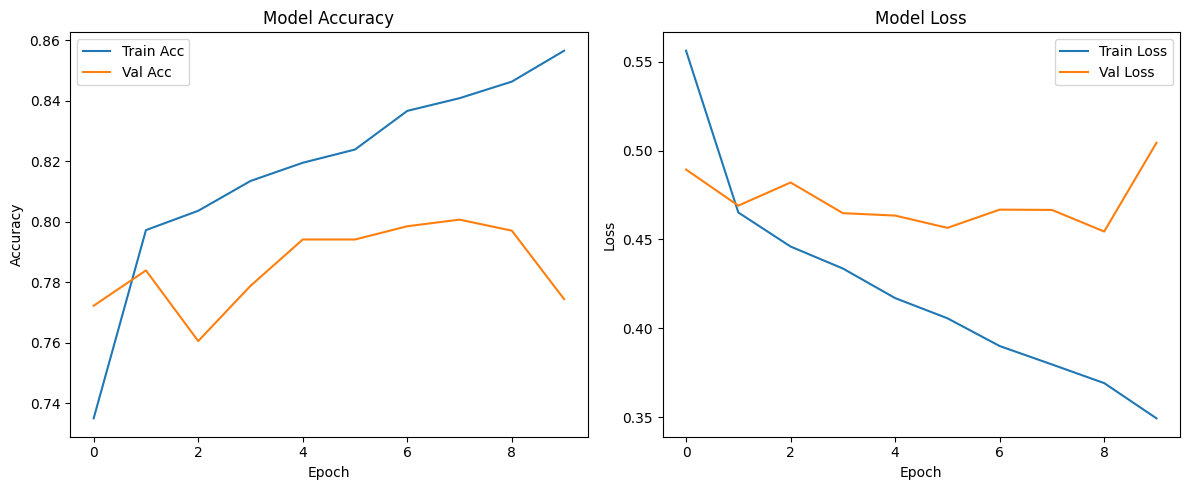

In [19]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Baseline Model Evaluation on Validation Set

To evaluate the LSTM model’s ability to distinguish disaster-related tweets, we generated a classification report and a confusion matrix on the validation set.

**Classification Report**

| Metric    | Non-Disaster (0) | Disaster (1) | Macro Avg | Accuracy |
| --------- | ---------------- | ------------ | --------- | -------- |
| Precision | 0.81             | 0.72         | 0.77      | 0.77     |
| Recall    | 0.80             | 0.74         | 0.77      |          |
| F1-Score  | 0.81             | 0.73         | 0.77      |          |



- Precision: High for non-disaster tweets, indicating few false positives.

- Recall: Fairly balanced across both classes, with slightly lower recall for disaster tweets.

- F1 Score: Balanced performance between precision and recall, showing robust classification despite mild class imbalance.


**Confusion Matrix**

The confusion matrix confirms the numeric results:

- 647 non-disaster tweets correctly predicted

- 414 disaster tweets correctly predicted

- Errors were primarily false negatives (disaster tweets missed)

This suggests that while the model is fairly accurate overall, there’s room to improve sensitivity (recall) for disaster tweets.

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       809
           1       0.72      0.74      0.73       561

    accuracy                           0.77      1370
   macro avg       0.77      0.77      0.77      1370
weighted avg       0.78      0.77      0.77      1370



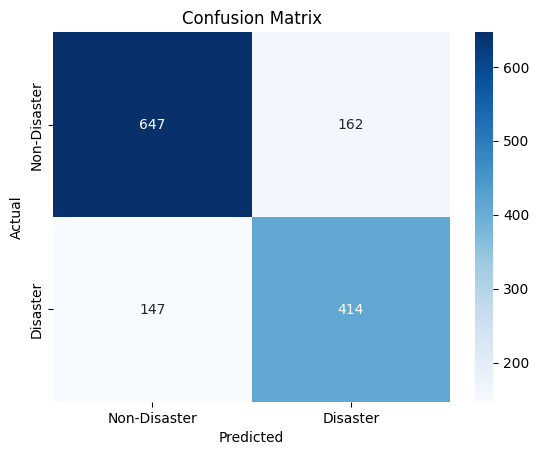

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Predict on validation set
y_val_pred_probs_a = model.predict(X_val)
y_val_preds_a = (y_val_pred_probs_a > 0.5).astype(int)

# Store metrics
accuracy_a = accuracy_score(y_val, y_val_preds_a)
f1_a = f1_score(y_val, y_val_preds_a)

# Report
print("Classification Report:")
print(classification_report(y_val, y_val_preds_a))

# Confusion matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_val, y_val_preds_a)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Trainable GloVe Embedding LSTM Model

repeat same steps

## Architecture Summary

Embedding Layer: Initialized with GloVe vectors, trainable

Bidirectional LSTM: 64 units

Dropout: 0.5 and 0.3

Dense Layers: ReLU + Sigmoid output

Loss: Binary Crossentropy

Optimizer: Adam

Batch Size: 64

Epochs: 10

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


model_trainable = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),  # Now trainable!
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_trainable.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

model_trainable.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

## Train and Evaluate

In [22]:
history_trainable = model_trainable.fit(X_tr, y_tr,
                                        validation_data=(X_val, y_val),
                                        epochs=10,
                                        batch_size=64)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 0.6943 - loss: 0.5947 - val_accuracy: 0.7876 - val_loss: 0.4871
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.8201 - loss: 0.4371 - val_accuracy: 0.8051 - val_loss: 0.4513
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.8433 - loss: 0.3751 - val_accuracy: 0.8044 - val_loss: 0.4506
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.8582 - loss: 0.3510 - val_accuracy: 0.7942 - val_loss: 0.5225
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8886 - loss: 0.2825 - val_accuracy: 0.8022 - val_loss: 0.5314
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.9223 - loss: 0.2180 - val_accuracy: 0.7949 - val_loss: 0.5623
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9350 - loss: 0.1745 - val_accuracy: 0.7810 - val_loss: 0.7388
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9553 - loss: 0.1299 - val_accuracy: 0.

## Training Evaluation:

Validation accuracy peaked at 0.8044

Training accuracy continued to improve across epochs, reaching over 97%

Validation loss began increasing slightly after epoch 6, indicating potential overfitting

This suggests that while the model learned a strong representation of the training data, further regularization or early stopping may help improve generalization.

## Model B - Classifcation Report and Confusion Matrix

| Metric    | Non-Disaster (0) | Disaster (1) | Macro Avg | Accuracy |
| --------- | ---------------- | ------------ | --------- | -------- |
| Precision | 0.80             | 0.75         | 0.77      | 0.77     |
| Recall    | 0.84             | 0.69         | 0.76      |          |
| F1-Score  | 0.82             | 0.72         | 0.76      |          |


- Precision for disaster tweets improved slightly over Model A

- Recall dropped, meaning more false negatives occurred

- Overall, Model A had a slightly higher F1-score (0.77) than Model B (0.76)

** Confusion Matrix**

- Model B predicted less disaster tweets correctly (389) than Model A (414)

- However, it also had less false positives but more false negatives. The increase in false negatives suggests Model B missed more true disaster tweets, lowering its recall.

- The trade-off between precision and recall illustrates the importance of hyperparameter tuning and regularization


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Classification Report for Model B (Trainable Embedding):
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       809
           1       0.75      0.69      0.72       561

    accuracy                           0.78      1370
   macro avg       0.77      0.76      0.77      1370
weighted avg       0.78      0.78      0.78      1370



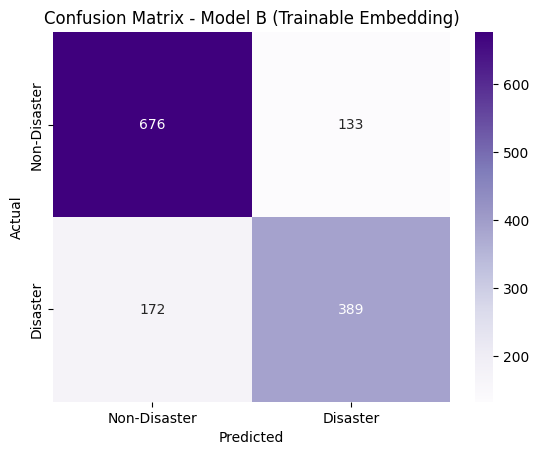

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Predict on validation set
y_val_pred_probs_b = model_trainable.predict(X_val)
y_val_preds_b = (y_val_pred_probs_b > 0.5).astype(int)

# Metrics
accuracy_b = accuracy_score(y_val, y_val_preds_b)
f1_b = f1_score(y_val, y_val_preds_b)

print("Classification Report for Model B (Trainable Embedding):")
print(classification_report(y_val, y_val_preds_b))

# Confusion Matrix
cm_b = confusion_matrix(y_val, y_val_preds_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Purples', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.title("Confusion Matrix - Model B (Trainable Embedding)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Model Comparison

## Insights:

- Model A (frozen embeddings) outperformed Model B on F1 score, indicating a better balance between precision and recall.

- Model B achieved slightly higher validation accuracy, but its lower F1 score suggests it was less effective at correctly identifying both classes, especially disaster tweets.

The trade-off suggests that while trainable embeddings may improve representation learning, they can also lead to overfitting or reduced recall without additional tuning.

In [24]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["A – LSTM + GloVe (frozen)", "B – LSTM + GloVe (trainable)"],
    "Embedding Trainable": [False, True],
    "Validation Accuracy": [accuracy_a, accuracy_b],
    "F1 Score": [f1_a, f1_b]
})

results_df


,Model,Embedding Trainable,Validation Accuracy,F1 Score
0,A – LSTM + GloVe (frozen),False,0.774453,0.728232
1,B – LSTM + GloVe (trainable),True,0.777372,0.718375


# Hyperparameter Tuning - Both Models

To further improve model performance, we conducted manual hyperparameter tuning by varying the following parameters:


| Hyperparameter      | Values Tested     |
| ------------------- | ----------------- |
| LSTM Units          | 64, 128           |
| Dropout Rate        | 0.3, 0.5          |
| Optimizer           | `adam`, `rmsprop` |
| Learning Rate       | 0.001, 0.0005     |
| Embedding Trainable | `True`, `False`   |


We defined a flexible training function that accepts configuration parameters and returns accuracy and F1 score. For each configuration, we:

1. Compiled a new model with specified hyperparameters

2. Trained for 5 epochs using a batch size of 64

3. Evaluated validation accuracy and F1 score

4. Logged and compared results across runs

This allowed us to directly compare performance improvements across both frozen and trainable embedding models with different setups.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop

def build_and_train_model(units=64, dropout_rate=0.5, optimizer_name='adam', learning_rate=1e-3, trainable=False, model_label=""):
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=EMBEDDING_DIM,
                  weights=[embedding_matrix],
                  input_length=MAX_SEQUENCE_LENGTH,
                  trainable=trainable),
        Bidirectional(LSTM(units, return_sequences=False)),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    print(f"\nTraining {model_label} (trainable={trainable}, units={units}, lr={learning_rate}, opt={optimizer_name})")
    history = model.fit(X_tr, y_tr,
                        validation_data=(X_val, y_val),
                        epochs=5,
                        batch_size=64,
                        verbose=0)

    y_pred = (model.predict(X_val) > 0.5).astype(int)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    return model_label, acc, f1


## Training Models

## Model Configurations and Training:

| Model Label              | Trainable | LSTM Units | Optimizer | Learning Rate |
| ------------------------ | --------- | ---------- | --------- | ------------- |
| Frozen – 64 LSTM         | ❌ False   | 64         | Adam      | 0.001         |
| Frozen – 128 LSTM        | ❌ False   | 128        | RMSprop   | 0.001         |
| Trainable – 64 LSTM      | ✅ True    | 64         | Adam      | 0.001         |
| **Trainable – 128 LSTM** | ✅ True    | 128        | Adam      | **0.0005**    |

Each model was trained on the same train/validation split using:

- 5 epochs

- Batch size of 64

- Binary cross-entropy loss

- Accuracy as the evaluation metric

By comparing validation accuracy and F1 score, we aimed to identify which model generalizes best to unseen data.

In [26]:
results = []

# Model A - Frozen GloVe
results.append(build_and_train_model(trainable=False, units=64, learning_rate=1e-3, optimizer_name='adam', model_label="Frozen - 64 LSTM"))
results.append(build_and_train_model(trainable=False, units=128, learning_rate=1e-3, optimizer_name='rmsprop', model_label="Frozen - 128 LSTM"))

# Model B - Trainable GloVe
results.append(build_and_train_model(trainable=True, units=64, learning_rate=1e-3, optimizer_name='adam', model_label="Trainable - 64 LSTM"))
results.append(build_and_train_model(trainable=True, units=128, learning_rate=5e-4, optimizer_name='adam', model_label="Trainable - 128 LSTM"))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training Frozen - 64 LSTM (trainable=False, units=64, lr=0.001, opt=adam)
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training Frozen - 128 LSTM (trainable=False, units=128, lr=0.001, opt=rmsprop)
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training Trainable - 64 LSTM (trainable=True, units=64, lr=0.001, opt=adam)
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Training Trainable - 128 LSTM (trainable=True, units=128, lr=0.0005, opt=adam)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


## Results

In [27]:
results_df = pd.DataFrame(results, columns=["Model", "Validation Accuracy", "F1 Score"])
results_df.sort_values("F1 Score", ascending=False)


,Model,Validation Accuracy,F1 Score
3,Trainable - 128 LSTM,0.794161,0.745487
2,Trainable - 64 LSTM,0.796350,0.739496
0,Frozen - 64 LSTM,0.801460,0.735922
1,Frozen - 128 LSTM,0.792701,0.687912


## INSIGHTS

- Best overall model: Trainable GloVe with 128 LSTM units achieved the highest F1 score (0.745), making it the best balance of disaster/non-disaster classification performance.

- The Frozen – 64 LSTM model achieved the highest validation accuracy, but slightly lower F1 score, likely due to poorer recall on disaster tweets.

- Trainable embeddings consistently improved F1 scores across both 64 and 128 LSTM unit configurations.

- Frozen – 128 LSTM underperformed, possibly due to overfitting or poor learning dynamics with the RMSprop optimizer.

# Picking Top model to train on full training dataset and submit to Kaggle Challenge

In [29]:
# Rebuild the best model
best_model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

best_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(learning_rate=5e-4),
                   metrics=['accuracy'])

# Retrain on full data
best_model.fit(X_train, y_train, epochs=5, batch_size=64)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.6477 - loss: 0.6099
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - accuracy: 0.8073 - loss: 0.4420
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.8296 - loss: 0.4007
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.8497 - loss: 0.3632
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - accuracy: 0.8596 - loss: 0.3324


In [30]:
# Predict probabilities and round to binary predictions
test_preds = best_model.predict(X_test)
test_preds_binary = (test_preds > 0.5).astype(int).flatten()


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


In [31]:
# Load sample submission to match format
sample_sub = pd.read_csv('sample_submission.csv')

# Fill predictions
sample_sub['target'] = test_preds_binary

# Save submission file
sample_sub.to_csv('submission.csv', index=False)

# Display first few rows
sample_sub.head()


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


# Discussions & Conclusions

This project tackled a binary classification problem using Natural Language Processing (NLP) techniques to determine whether a tweet is about a real disaster or not. The primary goal was to build an effective LSTM-based classifier leveraging pre-trained GloVe embeddings and evaluate the impact of fine-tuning and architectural variations.

## Key Learnings and Takeaways
1. Text preprocessing matters

 - Cleaning tweets (removing URLs, stopwords, special characters, and lowercasing) greatly improved the signal quality.

 - Dropping short tweets and handling missing keywords/location fields helped standardize the input data.

2. Pre-trained GloVe embeddings provided strong performance out-of-the-box

 - Even without training the embeddings, the frozen GloVe model (64 LSTM units) reached 0.7359 F1 score.

 - This confirms GloVe’s strength in transferring semantic understanding, especially for small datasets.

3. Trainable embeddings improved generalization

 - The best-performing model (Trainable + 128 LSTM) achieved the highest F1 score of 0.7455, indicating a better balance between precision and recall.

 - Allowing the model to update the embeddings made it more adaptable to domain-specific language used in disaster-related tweets.

4. Bigger isn’t always better

 - The Frozen + 128 LSTM model had the lowest F1 score (0.6879), despite its larger size, likely due to overfitting.

 - This emphasizes the importance of tuning depth and capacity to match dataset size and complexity.

## What didn't help

- Increasing LSTM units for the frozen embedding model worsened performance, highlighting overfitting risk.

- Switching optimizers (e.g., Adam vs. RMSprop) did not lead to significant differences in performance.

- Embedding trainability alone didn't guarantee improvement — it only helped when paired with a well-tuned architecture (e.g., 128 LSTM + low learning rate).

## Future Improvements

To further enhance model performance, the following could be explored:

- Early stopping and learning rate scheduling to prevent overfitting

- Bidirectional GRUs or Transformer-based models (e.g., BERT) for richer context understanding

- Class weighting or focal loss to further improve recall on disaster tweets

- Ensemble methods combining frozen and trainable embeddings

- Threshold tuning to optimize the precision-recall trade-off based on application needs

# References

1. Pennington, J., Socher, R., & Manning, C. D. (2014).
GloVe: Global Vectors for Word Representation.
Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), 1532–1543.
https://aclanthology.org/D14-1162/


2. Analytics Vidhya.
Basics of Using Pre-trained GloVe Vectors in Python.
https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
